In [1]:
import random
import math
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import hydra

from botorch.test_functions import *

from palettable.cartocolors import qualitative as qual_palettes

sns.set(style="white", font_scale=1.75)

In [2]:
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cpu


In [3]:
temp_range = 10. ** (-1 * np.arange(2, 7, 2))
dim_range = 2 ** np.arange(0, 1)

In [4]:
import sys
sys.path.append('../conformalbo')
sys.path.append('../experiments')

In [5]:
num_mix_components = 1
base_seed = 2022

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)

def sample_mixture(x_dim, device, dtype):
    sobol_eng = torch.quasirandom.SobolEngine(dimension=x_dim, scramble=True)
    mix_loc = sobol_eng.draw(num_mix_components).to(device=device, dtype=dtype)

    # makes separation more extreme
    # rand_mask = (torch.rand_like(base_samples) < 0.5).to(base_samples)
    # mix_loc = 0.5 * rand_mask + 0.5 * base_samples

    mix_scale = torch.full_like(mix_loc, math.sqrt(5e-3))
    mix_dist = torch.distributions.Normal(mix_loc, mix_scale)
    return mix_dist

Text(0.5, 0, '$x$')

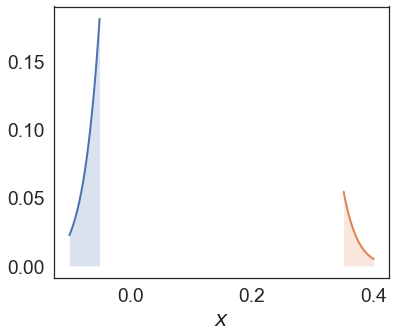

In [6]:
set_seed(base_seed)

x = torch.linspace(-0.1, 0.4, 1000, device=device, dtype=dtype)
mix_dist = sample_mixture(1, device, dtype)
component_logp = mix_dist.log_prob(x)

x = x.cpu()
component_logp = component_logp.cpu()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1)
# for mix_idx in range(num_mix_components):
#     p_x = component_logp[mix_idx].exp()
#     ax.plot(x, p_x, linewidth=1, linestyle='--')
#     ax.fill_between(x, torch.zeros_like(x), p_x, alpha=0.2)
    
# plot mixture distribution
p_x = component_logp.exp().mean(0)
ax.plot(x[:100], p_x[:100], linewidth=2)
ax.fill_between(x[:100], torch.zeros_like(x)[:100], p_x[:100], alpha=0.2)

ax.plot(x[900:], p_x[900:], linewidth=2)
ax.fill_between(x[900:], torch.zeros_like(x)[900:], p_x[900:], alpha=0.2)

ax.set_xlabel(r'$x$')

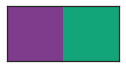

In [7]:
palette = qual_palettes.Bold_2.hex_colors
sns.palplot(palette)
sns.set_palette(palette)

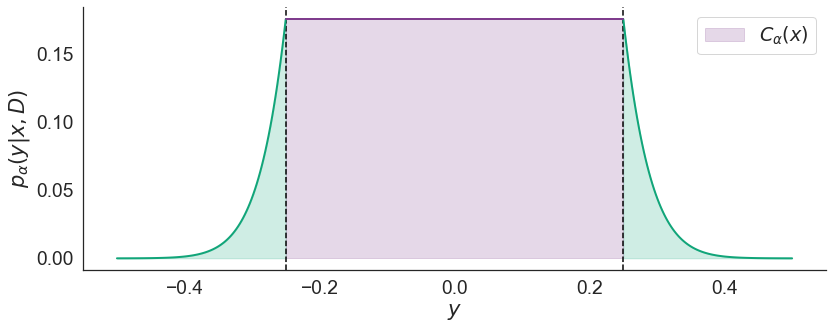

In [13]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 1, 1)

mix_dist = torch.distributions.Normal(torch.zeros(1, 1), 0.1 * torch.ones(1, 1))
                                      
x = torch.linspace(-0.5, -0.25, 100, device=device, dtype=dtype)
component_logp = mix_dist.log_prob(x)
x = x.cpu()
component_logp = component_logp.cpu()                                    
p_x = component_logp.exp().mean(0)
ax.plot(x, p_x, linewidth=2, color=palette[1])
ax.fill_between(x, torch.zeros_like(x), p_x, alpha=0.2, color=palette[1])

plt.ylim(plt.ylim())
plt.vlines(x[-1], *plt.ylim(), color='black', linestyle='--')

x = torch.linspace(0.25, 0.5, 100, device=device, dtype=dtype)
component_logp = mix_dist.log_prob(x)
x = x.cpu()
component_logp = component_logp.cpu()                                    
p_x = component_logp.exp().mean(0)
ax.plot(x, p_x, linewidth=2, color=palette[1])
ax.fill_between(x, torch.zeros_like(x), p_x, alpha=0.2, color=palette[1])

plt.vlines(x[0], *plt.ylim(), color='black', linestyle='--')

x = torch.linspace(-0.25, 0.25, 100, device=device, dtype=dtype)
component_logp = mix_dist.log_prob(x)
x = x.cpu()
component_logp = component_logp.cpu()                                    
p_x = torch.full_like(x, p_x[0])
ax.plot(x, p_x, linewidth=2, color=palette[0])
ax.fill_between(x, torch.zeros_like(x), p_x, alpha=0.2, label=r'$C_\alpha(x)$', color=palette[0])


ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$p_\alpha(y | x, D)$')
plt.legend()
plt.tight_layout()
sns.despine()
plt.savefig('./figures/conf_bo_posterior_illustration_v0.0.1.pdf', bbox_inches='tight')

In [9]:
set_seed(base_seed)

num_trials = 32
trial_seeds = torch.randint(0, int(1e5), (num_trials,))
x_dim = 3
num_samples = 32

bb_fn = Hartmann(dim=3, negate=True, noise_std=math.sqrt(5e-2))
mix_dist = sample_mixture(x_dim, device, dtype)

In [10]:
from tabular.runner import fit_surrogate, set_alpha, evaluate_surrogate
import hydra

with hydra.initialize(config_path='../experiments/tabular/hydra_config'):
    cfg = hydra.compose(config_name='tabular_search', overrides=[])

records = []
for seed in trial_seeds:
    set_seed(seed)
    train_X = mix_dist.sample((num_samples,)).view(-1, x_dim)
    train_f = bb_fn.evaluate_true(train_X).view(-1, 1)
    train_Y = bb_fn(train_X).view(-1, 1)

    holdout_X = mix_dist.sample((num_samples,)).view(-1, x_dim)
    holdout_f = bb_fn.evaluate_true(holdout_X).view(-1, 1)
    holdout_Y = bb_fn(holdout_X).view(-1, 1)
    
    surrogate = fit_surrogate(train_X, train_Y)
    set_alpha(cfg, train_X.shape[-2])
    holdout_metrics = evaluate_surrogate(cfg, surrogate, holdout_X, holdout_Y, log_prefix='holdout')
    
    holdout_metrics['seed'] = seed
    holdout_metrics['num_train'] = num_samples
    holdout_metrics['sigmoid_temp'] = cfg.conformal_params.temp
    records.append(holdout_metrics)
                     
experiment_df = pd.DataFrame(records)

ModuleNotFoundError: No module named 'tabular'

In [ ]:
1 / math.sqrt(num_samples)